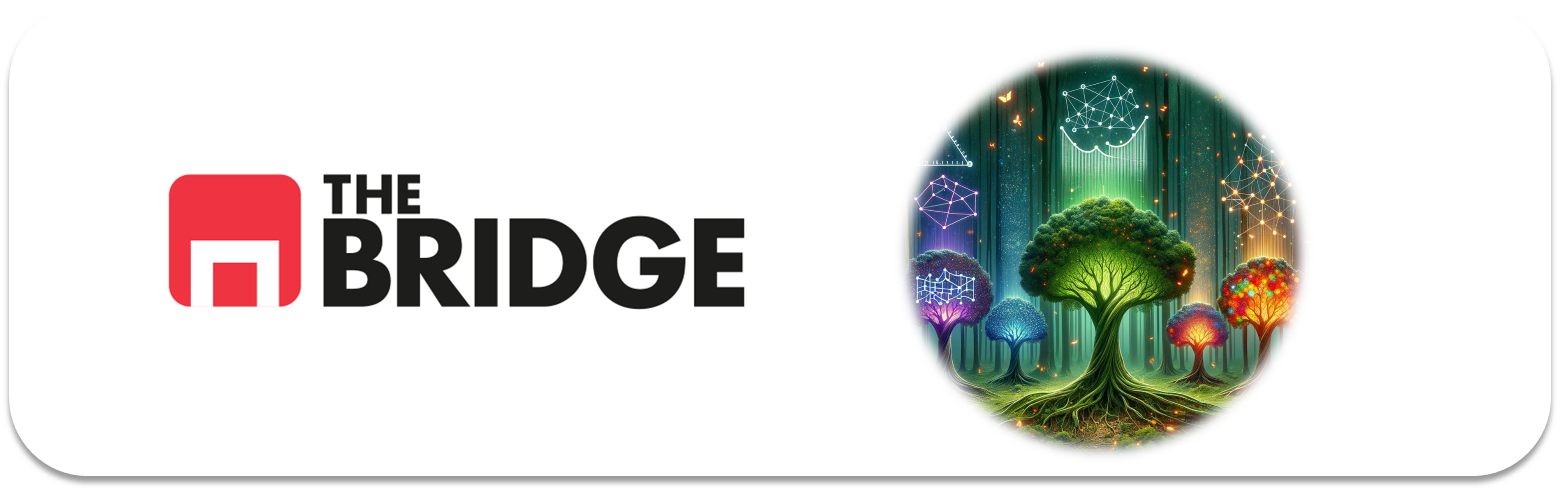

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [65]:
df_bank = pd.read_csv("data/bank-full.csv",sep=";")

In [66]:
df_bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [67]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [68]:
df_bank = df_bank.rename(columns={
    'poutcome': 'outcome',
    'pdays': 'days',
    'y': 'suscribed'
})

In [69]:
target = df_bank["suscribed"]

In [70]:
df_bank["suscribed"].value_counts()

suscribed
no     39922
yes     5289
Name: count, dtype: int64

<Axes: xlabel='suscribed', ylabel='count'>

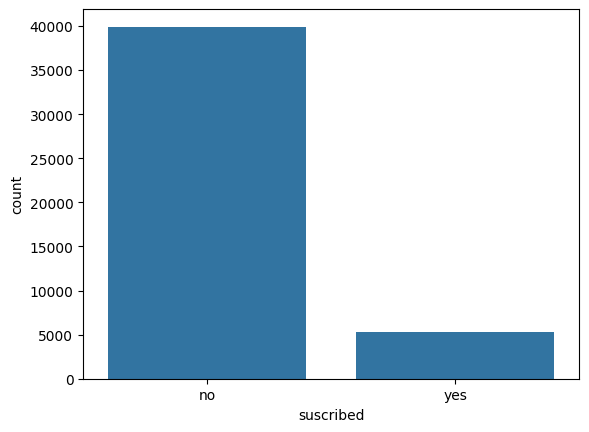

In [71]:
sns.countplot(data=df_bank, x='suscribed')

In [72]:
### Elimino variables que no creo importantes 

df_bank = df_bank.drop(columns=["duration", "day", "days", "contact", "month","default"])

In [73]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   loan       45211 non-null  object
 7   campaign   45211 non-null  int64 
 8   previous   45211 non-null  int64 
 9   outcome    45211 non-null  object
 10  suscribed  45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [74]:
train_set, test_set = train_test_split(df_bank, test_size= 0.2, stratify= df_bank["suscribed"],random_state= 42)

In [103]:
target="suscribed"

In [75]:
train_set["suscribed"].value_counts(normalize = True)

suscribed
no     0.883018
yes    0.116982
Name: proportion, dtype: float64

In [76]:
test_set["suscribed"].value_counts(normalize = True)

suscribed
no     0.883003
yes    0.116997
Name: proportion, dtype: float64

In [104]:
train_set[target].value_counts(normalize=True)

suscribed
no     0.883018
yes    0.116982
Name: proportion, dtype: float64

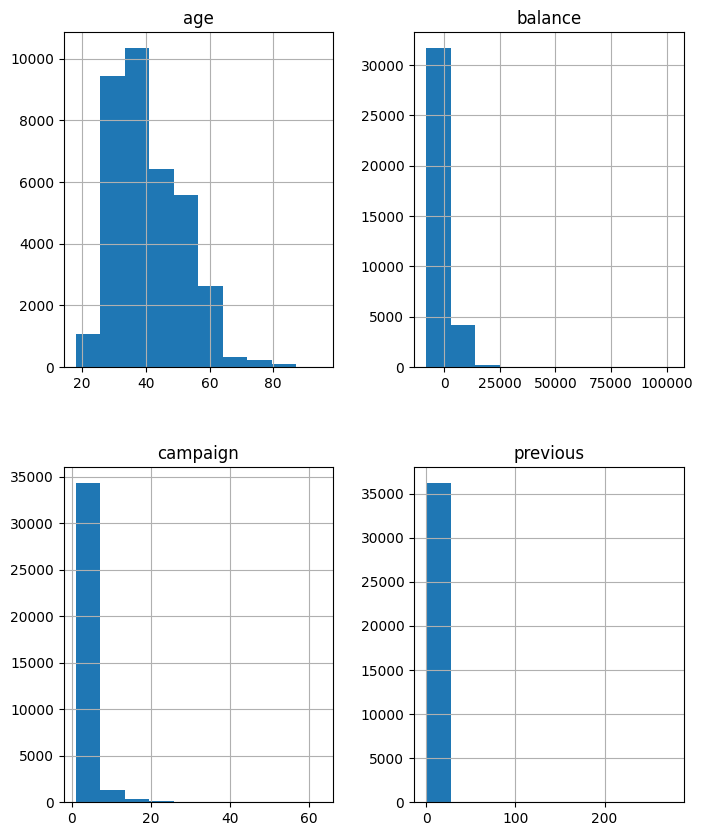

In [86]:
train_set.hist(figsize=(8, 10))
plt.show()

In [124]:
features_num = ["age","balance","campaign","previous"]

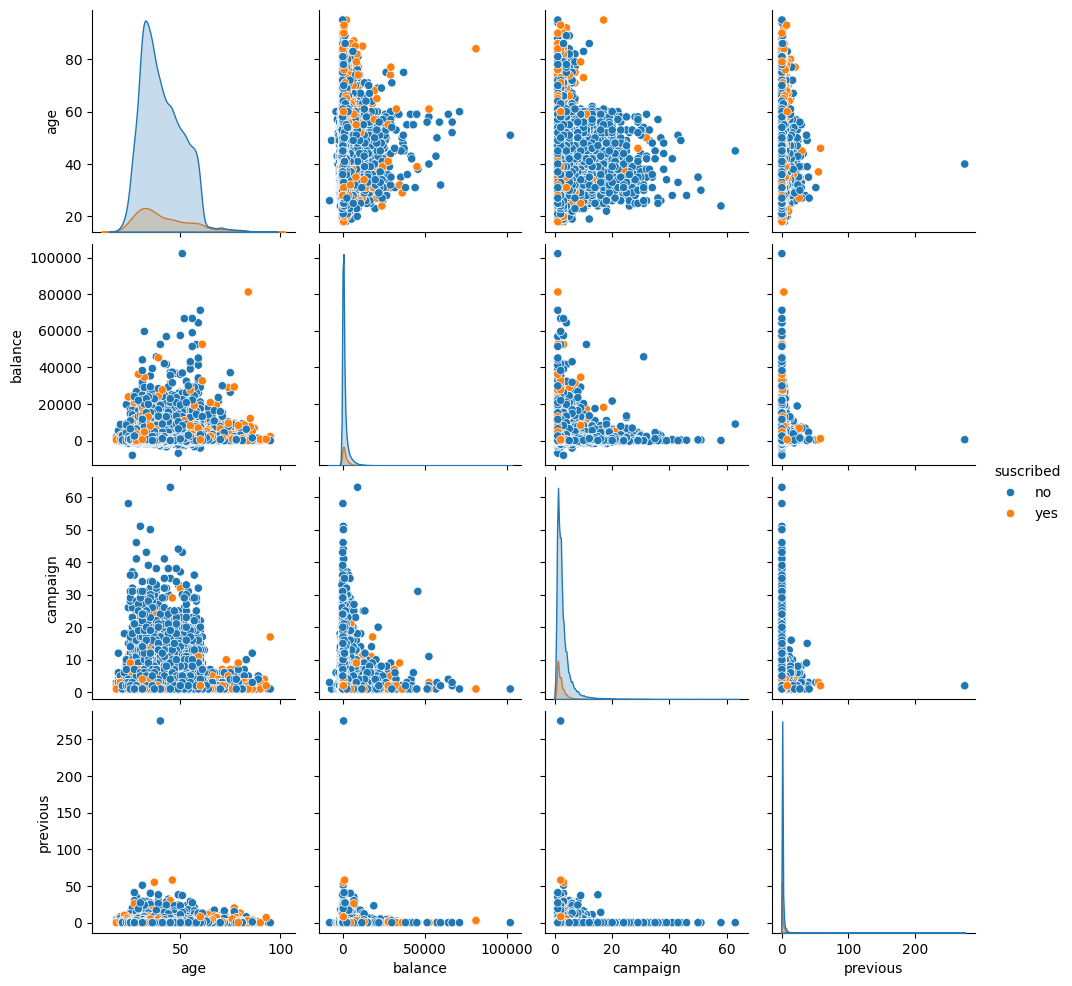

In [106]:
sns.pairplot(train_set[features_num + [target]], hue = target)

In [107]:
# Descartamos todas las variables numericas porque no discrima entre clases de nuestro objetivo
features_num = [] 

In [119]:
features_cat = ("job","marital","education","housing","loan","outcome")

In [120]:
from bootcampviztools import pinta_distribucion_categoricas

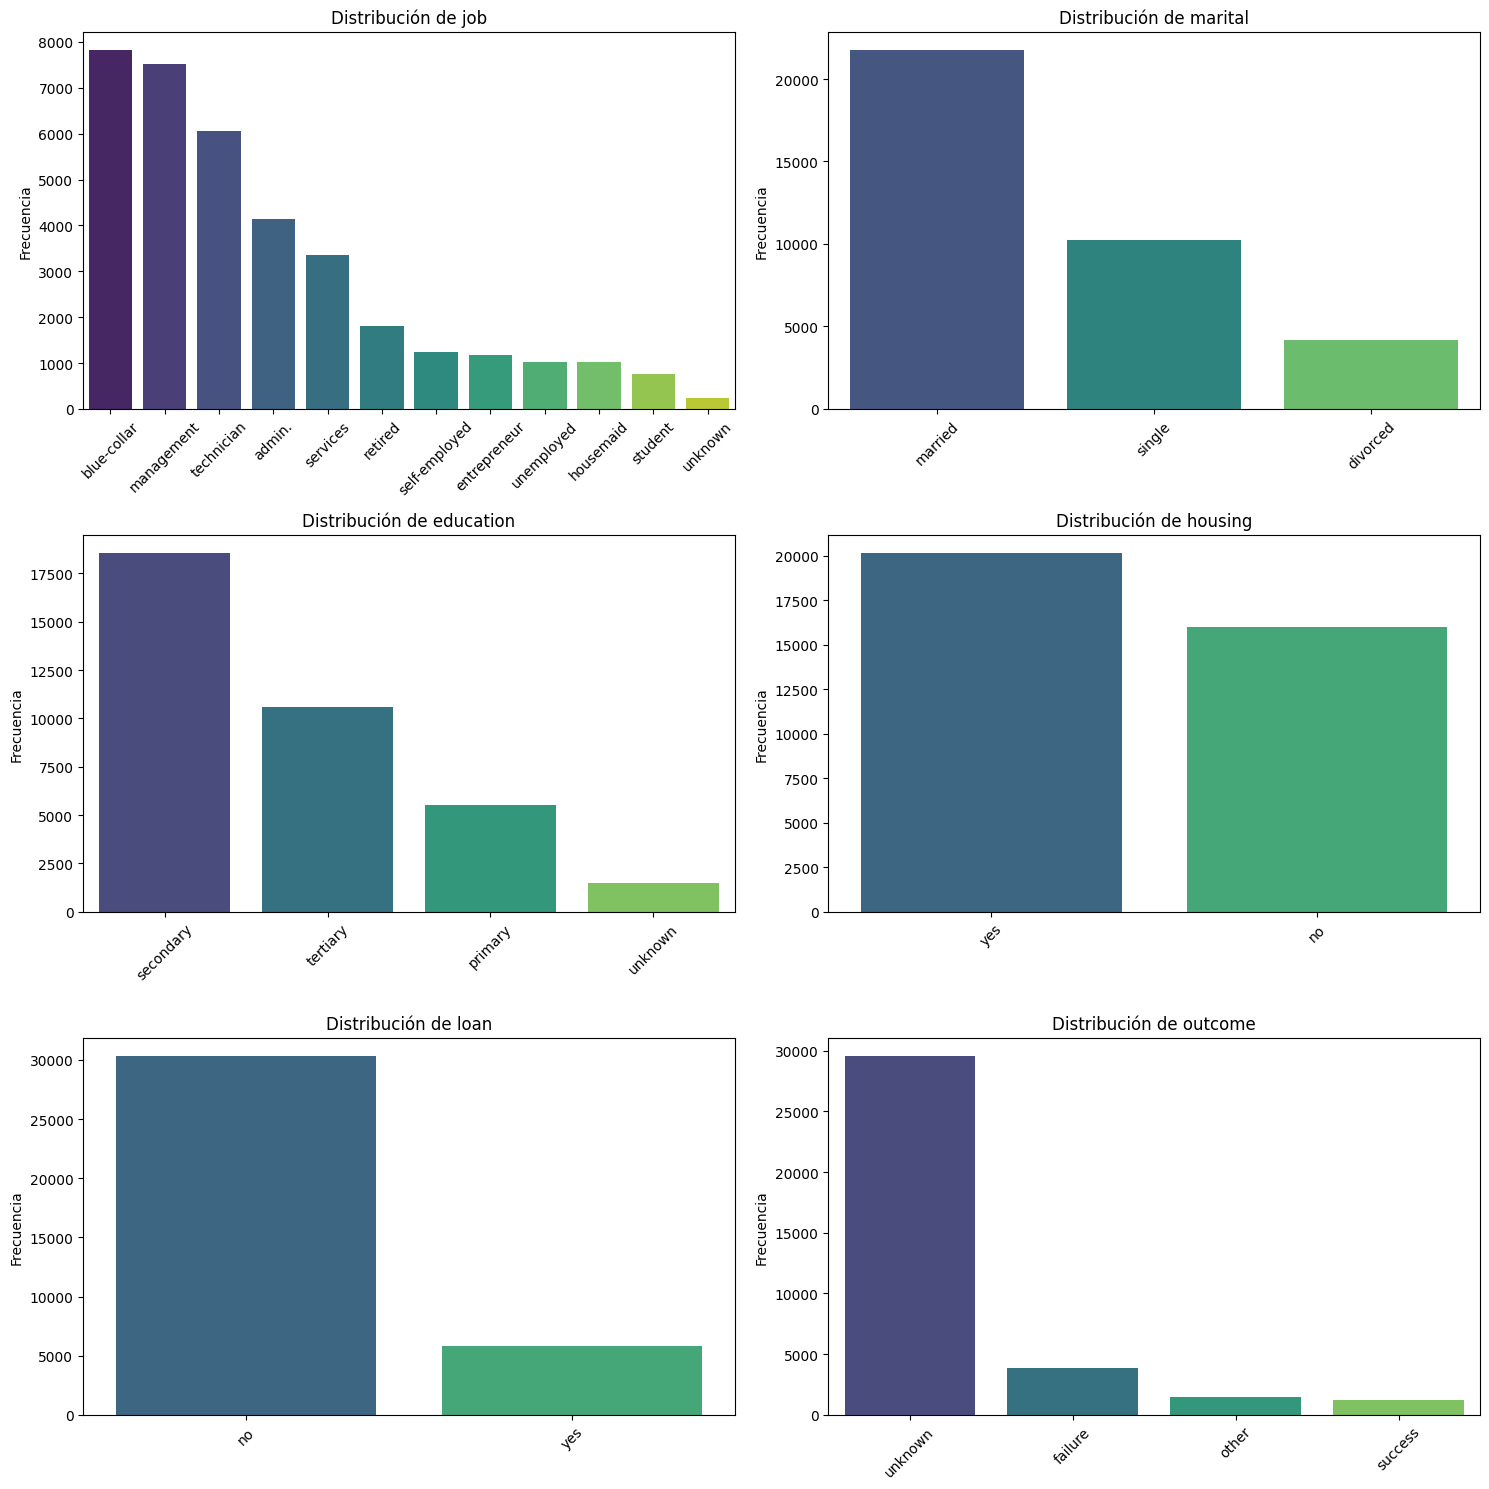

In [121]:
pinta_distribucion_categoricas(train_set, features_cat,relativa=False, mostrar_valores=False)

In [111]:
import bootcampviztools as bt

In [117]:
features_cat = ("job","marital","education","housing","loan","outcome")

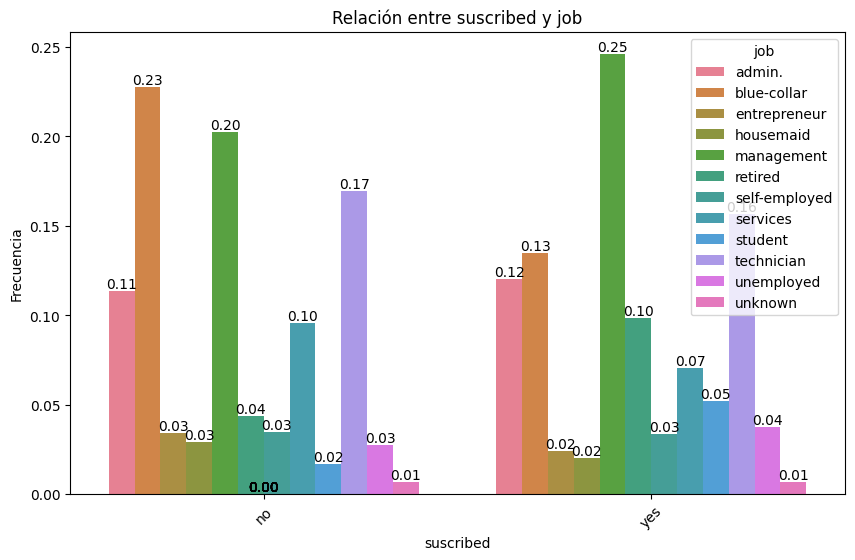

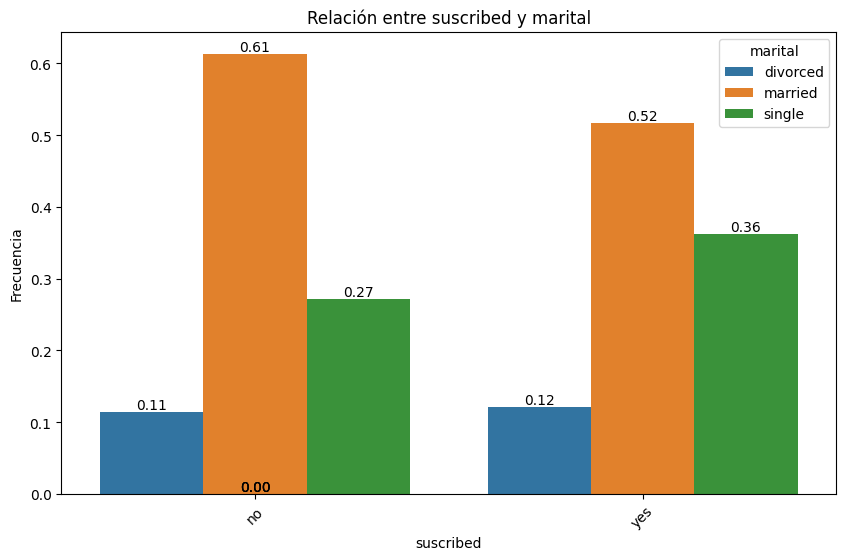

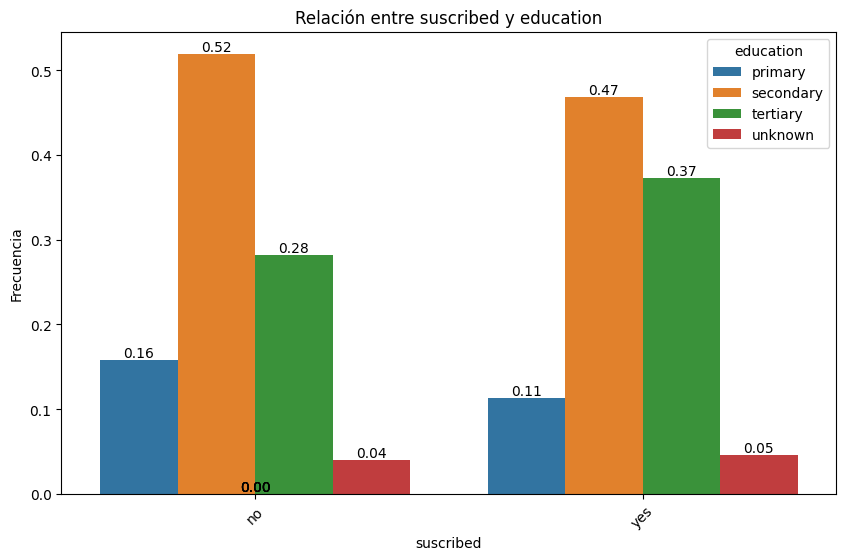

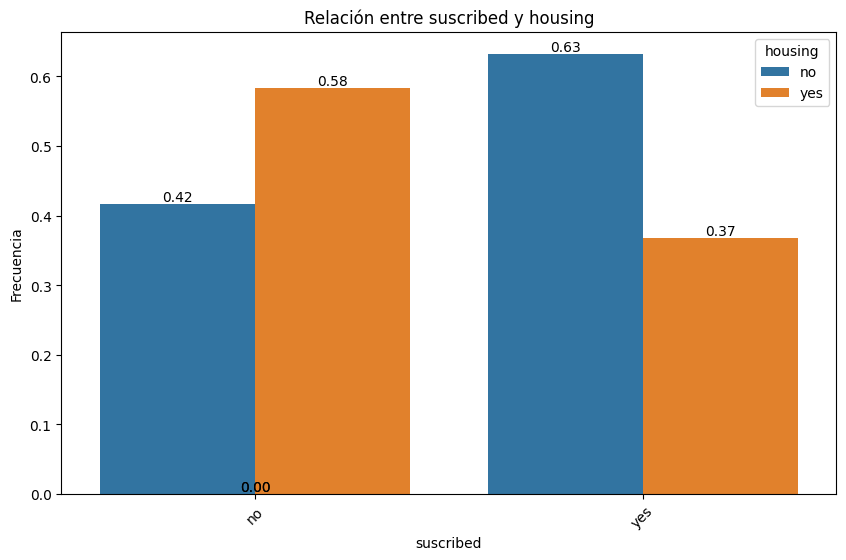

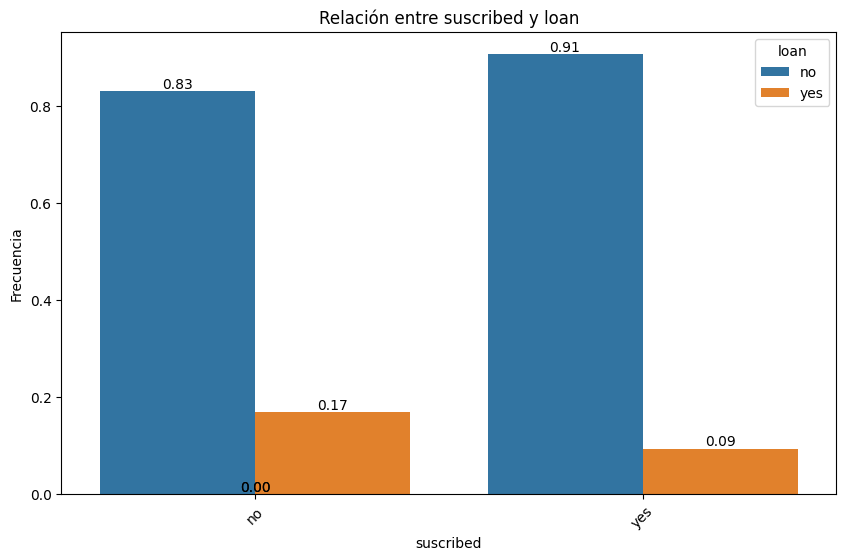

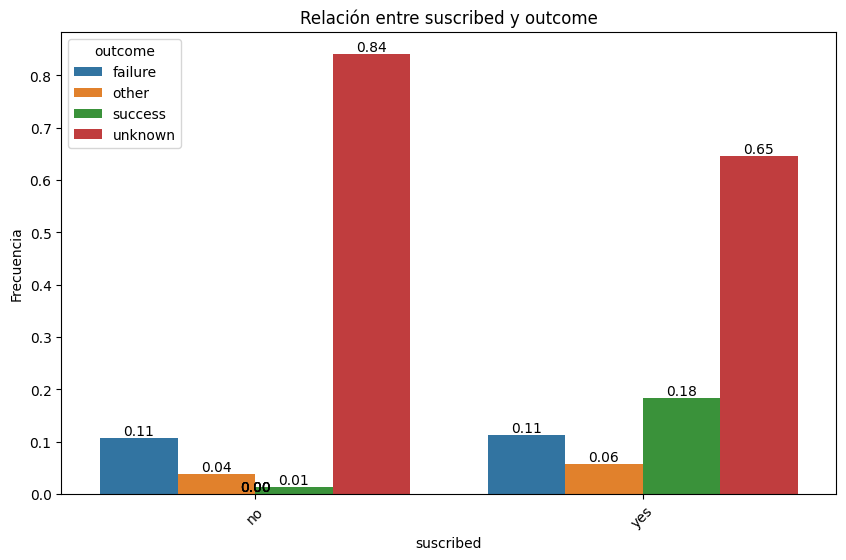

In [118]:
for feat in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, feat, show_values= True, relative_freq= True)

In [ ]:
### Eliminamos de trail y test las variables numericas
train_set.drop(columns=features_num ,inplace=True)

In [127]:
test_set.drop(columns=features_num ,inplace=True)

In [130]:
train_set.drop(columns="job" ,inplace=True)
test_set.drop(columns="job" ,inplace=True)

In [131]:
train_set.head(5)

,marital,education,housing,loan,outcome,suscribed
24001,divorced,secondary,no,no,unknown,no
43409,single,secondary,no,no,failure,yes
20669,single,secondary,yes,no,unknown,yes
18810,married,secondary,no,no,unknown,no
23130,married,secondary,no,no,unknown,no


In [137]:
train_set["suscribed"].value_counts()

suscribed
no     31937
yes     4231
Name: count, dtype: int64

In [138]:
from sklearn.preprocessing import OrdinalEncoder

In [144]:
categories = [["divorced","single","married"], ["primary","secondary","tertiary","unknown"], ["yes","no"],["yes","no"],
            ["success","other","failure","unknown"],["yes","no"]] 

encoder = OrdinalEncoder(categories= categories)

train_set[["marital","education","housing","loan","outcome","suscribed"]] = encoder.fit_transform(train_set[["marital","education","housing","loan","outcome","suscribed"]])
test_set[["marital","education","housing","loan","outcome","suscribed"]] = encoder.transform(test_set[["marital","education","housing","loan","outcome","suscribed"]])

In [145]:
train_set[["marital","education","housing","loan","outcome","suscribed"]]

,marital,education,housing,loan,outcome,suscribed
24001,0.0,1.0,1.0,1.0,3.0,1.0
43409,1.0,1.0,1.0,1.0,2.0,0.0
20669,1.0,1.0,0.0,1.0,3.0,0.0
18810,2.0,1.0,1.0,1.0,3.0,1.0
23130,2.0,1.0,1.0,1.0,3.0,1.0
...,...,...,...,...,...,...
17958,2.0,1.0,0.0,1.0,3.0,1.0
15941,1.0,1.0,0.0,1.0,3.0,1.0
16952,2.0,1.0,0.0,1.0,3.0,1.0
34781,1.0,2.0,0.0,1.0,3.0,1.0


In [147]:
X_train = train_set
y_train = train_set[target]

X_test = test_set
y_test = test_set[target]

In [152]:
log_clf= LogisticRegression(max_iter = 10000) # Hiperparámetros

log_clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [154]:
y_pred=log_clf.predict(X_test)

In [155]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1058
         1.0       1.00      1.00      1.00      7985

    accuracy                           1.00      9043
   macro avg       1.00      1.00      1.00      9043
weighted avg       1.00      1.00      1.00      9043



In [156]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [157]:
y_pred=tree_clf.predict(X_test)

In [158]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1058
         1.0       1.00      1.00      1.00      7985

    accuracy                           1.00      9043
   macro avg       1.00      1.00      1.00      9043
weighted avg       1.00      1.00      1.00      9043

